In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Asset metrics
from portfolio_stats import PortfolioStats

# Optimization
from workflow.tools.optimize import max_sharpe_mv_opt

# Objective function
from workflow.tools.metrics import neg_sharpe_ratio

# Walk forward modeling
from sklearn.model_selection import TimeSeriesSplit

# Misc.
from workflow.tools.utils import set_plot_style, strftime
from tqdm.auto import tqdm

set_plot_style()

In [2]:
# Load in data and segregate the returns
features = pd.read_csv("workflow/data/features.csv", index_col=0, parse_dates=True)
rets = features[[col for col in features.columns if "RET" in col]]
indices = features.drop(rets.columns, axis=1).columns
rets.columns = indices

rets.head()

,BONDS,COMMODITIES,STOCKS,VOLATILIITY
Date,,,,
2006-02-07,-0.000699,-0.029352,-0.009784,0.041313
2006-02-08,-0.000498,-0.004264,0.007168,-0.057548
2006-02-09,0.000598,0.009358,-0.001906,0.022352
2006-02-10,-0.002099,-0.018373,0.002065,-0.019239
2006-02-13,0.000700,-0.015646,-0.004533,0.036617


In [3]:
# Retrieve the start date of our testing period, matching with that of the neural networks
trading_days = 252
rebalance_after = 2
tss = TimeSeriesSplit(test_size=trading_days*rebalance_after)

dates = rets.index
test_start_idx = None

for train_idx, test_idx in tss.split(rets):
    test_start_idx = test_idx[0]
    break

test_start_idx

1933

In [28]:
# Initialize variables
n_assets = len(indices)
init_weights = np.array([1/n_assets] * n_assets)
unlvgd_allocations = pd.DataFrame(columns=indices, index=features.index)
lvgd_allocations = unlvgd_allocations.copy()
ew_allocations = unlvgd_allocations.copy()

sharpes = pd.Series(index=features.index, name="Sharpe Ratio")
ew_sharpes = sharpes.copy()

# Loop through dates starting from test_start_idx
for i in tqdm(range(test_start_idx, len(dates))):
    past_rets = rets.iloc[0:i].values  # Past returns up to current date

    # Non-leveraged and leveraged optimization
    sharpe, unlvgd_allocation = max_sharpe_mv_opt(init_weights, past_rets, leverage=False)
    _, lvgd_allocation = max_sharpe_mv_opt(init_weights, past_rets, leverage=True)

    # Equal weight portfolio
    ew_sharpe = - neg_sharpe_ratio(init_weights, past_rets)
    ew_sharpes.loc[dates[i]], ew_allocations.loc[dates[i]] = ew_sharpe, init_weights

    # Store results
    sharpes.loc[dates[i]], unlvgd_allocations.loc[dates[i]] = sharpe, unlvgd_allocation
    _, lvgd_allocations.loc[dates[i]] = _, lvgd_allocation

# Shift and drop NA to align data
unlvgd_allocations = unlvgd_allocations.shift().dropna()
lvgd_allocations = lvgd_allocations.shift().dropna()
ew_allocations = ew_allocations.shift().dropna()

sharpes = sharpes.shift().dropna()

  0%|          | 0/2520 [00:00<?, ?it/s]

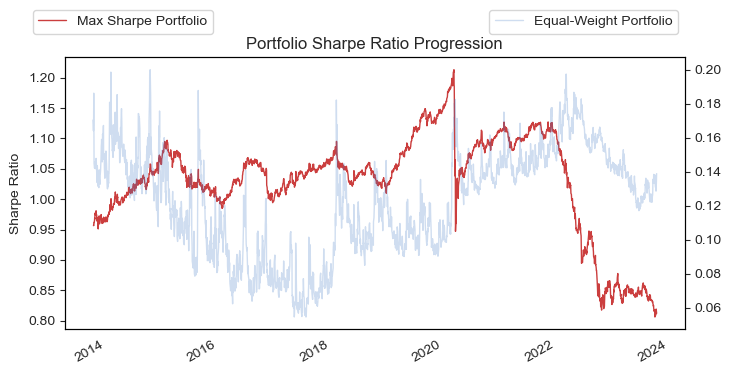

In [29]:
# Plot Sharpe ratio progression
ax = sharpes.plot(figsize=(8, 4), label=True, grid=False, color="#CB3E3E")
ax1 = ew_sharpes.plot(ax=ax.twinx(), grid=False, alpha=0.25, color="#4179C4")

ax.set_xlabel("")
ax.set_ylabel("Sharpe Ratio")
ax.legend(["Max Sharpe Portfolio"], bbox_to_anchor=(0.25, 1.2))
ax1.legend(["Equal-Weight Portfolio"], bbox_to_anchor=(1, 1.2))

plt.title("Portfolio Sharpe Ratio Progression")
plt.show()

In [35]:
print("Max Sharpe Portfolio --")
print("{:<15} {:<10,.2f} {:<15}".format("Max Sharpe", sharpes.max(), strftime(sharpes.idxmax())))
print("{:<15} {:<10,.2f} {:<15}".format("Min. Sharpe", sharpes.min(), strftime(sharpes.idxmin())))
print()
print("Equal-Weight Portfolio --")
print("{:<15} {:<10,.2f} {:<15}".format("Max Sharpe", ew_sharpes.max(), strftime(ew_sharpes.idxmax())))
print("{:<15} {:<10,.2f} {:<15}".format("Min. Sharpe", ew_sharpes.min(), strftime(ew_sharpes.idxmin())))

Max Sharpe Portfolio --
Max Sharpe      1.21       03/10/2020     
Min. Sharpe     0.81       10/05/2023     

Equal-Weight Portfolio --
Max Sharpe      0.20       10/17/2014     
Min. Sharpe     0.05       07/24/2017     


In [36]:
# Initialize allocations dictionary
allocations = {
    "LVGD": lvgd_allocations,
    "EW": ew_allocations,
    "UNLVGD": unlvgd_allocations
}

# Set transaction variables
trnsc_cr = 0.002  # 0.2% transaction cost rate

# Set loan variables
loan_term = 2     # 2Y repayment schedule
loan_ir = 0.05    # 5% interest rate
days_in_year = 365

amrtzn = 1 / (days_in_year * loan_term)
ir = loan_ir / days_in_year

port_rets_list = []

# Loop over allocations
for portfolio, allocation in allocations.items():
    port_rets = (allocation * rets).dropna().sum(axis=1)

    # Account for transaction costs
    wc = allocation.diff().abs().sum(axis=1)
    tc = wc * trnsc_cr
    port_rets = port_rets - tc

    # Account for principal repayment and borrowing costs for the leveraged portfolio
    if portfolio == "LVGD":
        lvg = (allocation.sum(axis=1) - 1)
        bc = (lvg * ir).diff()
        pr = (lvg * amrtzn).diff()
        port_rets = port_rets - bc - pr

    port_rets.name = portfolio
    port_rets_list.append(port_rets)

In [46]:
# Combine dataframes
mv_rets = pd.concat(port_rets_list, axis=1)
mv_rets.loc[mv_rets.index.min()] = 0

# Save returns
mv_rets.to_csv("workflow/data/returns/mv_rets.csv")